In [16]:
# ===================================
# !!! SET UP PATH AND MERGE FILES !!!
# ===================================

import csv
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import os
import matplotlib.pyplot as plt 
from scipy import stats

Nchunk = 20
trials = 1e4
directory = '/home/ambra/Desktop/cluster-morgana/archive_tests/tesi_04_lightcurve/'
lc10 = ['tesi_tdel50_degFalse_10s.csv',
        'tesi_tdel50_degTrue_10s.csv']
lc100 = ['tesi_tdel50_degFalse_100s.csv',
        'tesi_tdel50_degTrue_100s.csv']
lc_all = lc10 + lc100

os.system('mkdir %spng' %(directory))

256

In [17]:
# data params ---!
threshold = 0.5
ts_threshold = 25
xlim=0.2
# initialize SphDistance calc ---!
trueRA = 33.057
trueDEC = -51.841
true_coord = SkyCoord(ra = trueRA*u.deg, dec = trueDEC*u.deg, frame='fk5')
texp = [10, 100]
c1 = ['navy', 'firebrick']
c2 = ['deepskyblue', 'crimson']

In [18]:
# template ---!
pathin = '/home/ambra/Desktop/cluster-morgana/run0406_test/run0406/' 
path = pathin + 'run0406_ID000126/'
png = pathin + 'png/'
template = 'run0406_ID000126_ebl.fits'

hdul =  fits.open(pathin + template)

# energybins [GeV]
energy=np.array(hdul[1].data)
# timebins [s]
time=np.array(hdul[2].data)
# spectra [fotoni/GeV/cm^2/s]
spectra=np.array(hdul[3].data)
# ebl [fotoni/GeV/cm^2/s]
ebl=np.array(hdul[4].data)

Nt=len(time)
Ne=len(energy)

# TIME GRID ---!
t=[0.0 for x in range(Nt+1)]
for i in range(Nt-1):
    t[i+1]=time[i][0]+(time[i+1][0]-time[i][0])/2
# last bin
t[Nt]=time[Nt-1][0]+(time[Nt-1][0]-t[Nt-1])


# ENERGY GRID ---!
en=[1.0 for x in range(Ne+1)]
for i in range(Ne-1):
    en[i+1]=energy[i][0]+(energy[i+1][0]-energy[i][0])/2
# last bin
en[Ne]=energy[Ne-1][0]+(energy[Ne-1][0]-en[Ne-1])

# energy range ---!
LST = (min(en, key=lambda x:abs(x-20)), min(en, key=lambda x:abs(x-150)))
MST = (min(en, key=lambda x:abs(x-20)), min(en, key=lambda x:abs(x-10000)))
CTA = (min(en, key=lambda x:abs(x-30)), min(en, key=lambda x:abs(x-150000)))

# FLUX SPECTRA ---!
f=[]
for i in range(Nt):
    f.append(0.0)
    for j in range(Ne):
        f[i]=f[i]+spectra[i][j]*(en[j+1]-en[j])
        
# FLUX EBL ---!
f2=[]
for i in range(Nt):
    f2.append(0.0)
    for j in range(Ne):
        if en[j] <= CTA[1] and en[j] >= CTA[0]:
            f2[i]=f2[i]+ebl[i][j]*(en[j+1]-en[j])
            
print('done')

done


In [56]:
def lcPlot(flux, t1, uplims, t2, xerr, yerr, filename, temp_t, temp_f, sens, label='sens'):
    alpha = 1
    fontsize = 30
    if label == 'texp':
        lf = ['detections (texp=%ds)' %x(err[i]*2) for i in range(2)]
        lup = ['upper limits (texp=%ds)' %(xerr[i]*2) for i in range(2)]
    elif label == 'sens':
        lf = ['detections (texp=%ds), nominal' %(xerr[0]*2), 
              'detections (texp=%ds), degraded' %(xerr[1]*2)]
        lup = ['upper limits (texp=%ds), nominal' %(xerr[0]*2), 
               'upper limits (texp=%ds), degraded' %(xerr[1]*2)]
    
    fig = plt.figure(figsize=(20,16))
    plt.rc('text', usetex=True)
    sns.set()

    ax = plt.subplot(111, yscale='log', xscale='linear')    
    plt.xticks(fontsize=fontsize) # rotation=90
    plt.yticks(fontsize=fontsize) # rotation=90
    # template ---!
    plt.plot(temp_t[20:50], temp_f[20:50], '-g', lw=5, label='expected (30GeV-150TeV)', alpha=1)
    # detections ---!
    for i, f in enumerate(flux):
        print(f)
        print(t1[i])
        print(yerr[i][0])
        plt.errorbar(t1[i], f, xerr=np.array([xerr[i]]), 
                     yerr=np.array([yerr[i][0]]),
                     marker='o', c=c1[i], alpha=alpha, label=lf[i], ls='none', ms=10)
        plt.fill_between(t1[i][0], 
                         np.array(f[0])-np.array(yerr[i][0]), 
                         np.array(f[0])+np.array(yerr[i][0]), 
                         alpha=0.3, color=c1[i], interpolate=True)
        plt.axvline(t1[i][0][-1], ls='-.', lw=2, c=c1[i])
        plt.text(t1[i][0][-1]+100, 7e-9-1e-9*(i+1), '%d s' %t1[i][0][-1], color=c1[i], fontsize=fontsize)
    # upper limits ---!
    for i, u in enumerate(uplims):
        if len(u[0]) > 1:
            plt.errorbar(t2[i], u, xerr=np.array([xerr[i] for i in range(len(t2[i]))]), 
                         marker='v', c=c2[i], alpha=alpha, label=lup[i], ls='none', uplims=True)
            plt.axhline(sens[i], ls='-.', lw=2, c=c2[i])
            plateau = float(np.mean(uplims[i][0]))*1e9
            plt.text(30, float(np.mean(uplims[i][0]))*1.1, '%0.2fe-9 ph/cm$^2$/s' %plateau, 
                     color=c2[i], fontsize=fontsize+5)

    plt.ylabel('Flux (ph/cm$^2$/s)', fontsize=fontsize)
    plt.xlabel('time (s)', fontsize=fontsize)    
    plt.legend(fontsize=fontsize)
    plt.ylim([1e-10, 1e-8])
    plt.xlim([-1, 35e2])
    plt.show()
    fig.savefig(png_path+filename)
    


tesi_tdel50_degFalse_100s.csv
* verify trials =  95
95 95
plateau flux: nan
last detection: 3100.0

tesi_tdel50_degTrue_100s.csv
* verify trials =  86
86 86
plateau flux: nan
last detection: 2000.0
worst_nomVSdeg_100.png
[[4.8721942576630546e-09, 3.587607096774443e-09, 2.548832545106479e-09, 2.3360103218546294e-09, 2.3444338058487347e-09, 1.9776978718112597e-09, 1.6285657359822069e-09, 1.6601435981309527e-09, 1.2001351239842142e-09, 1.0275062776243638e-09, 9.251325462365683e-10, 8.606441245288223e-10, 7.91813828204627e-10, 6.621362775186037e-10, 5.732992763373309e-10, 7.832507167723289e-10, 4.914989629347366e-10, 4.4805297563114965e-10, 6.148099275259377e-10, 5.808863852136121e-10, 4.2179791641887624e-10, 3.4206910675670573e-10, 3.951815612696153e-10, 2.829815398465492e-10, 3.4943529029390223e-10]]
[[100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0, 1300.0, 1400.0, 1500.0, 1600.0, 1700.0, 1800.0, 1900.0, 2000.0, 2100.0, 2300.0, 2400.0, 2900.0, 3100

ValueError: operands could not be broadcast together with shapes (16,) (25,) 

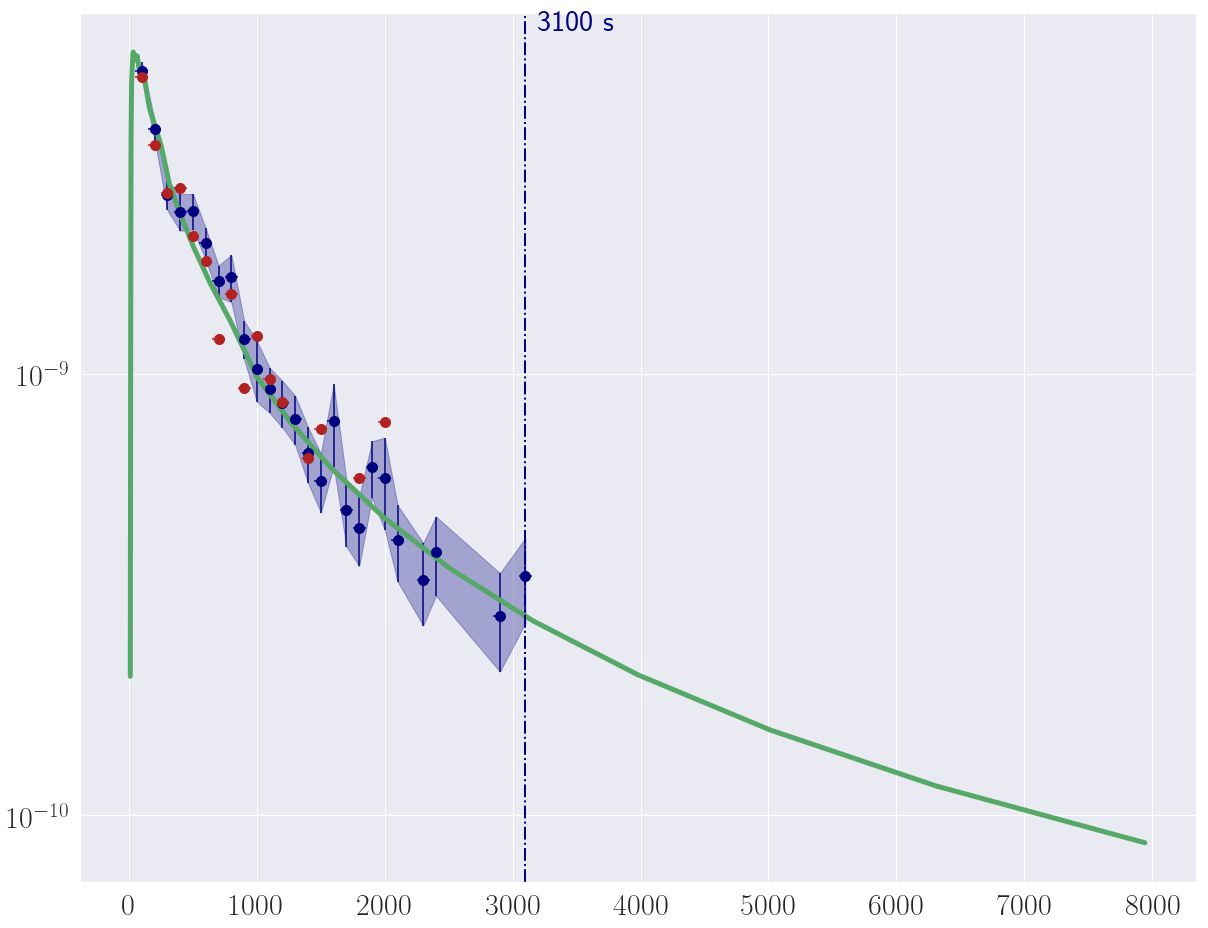

In [57]:
# =============================
# !!! ALL STATISTICAL PLOTS !!!
# =============================

import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from scipy.stats import rayleigh, norm
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse, Circle, Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
sys.path.append('/home/ambra/Desktop/cluster-morgana/')
from module_statistics import *
from statistics import mean

f10 = [6.95e-10, 9.98e-10]
f100 = [2.82e-10, 4.06e-10]
list_t1, list_t2, list_f, list_up, yerr, list_errF = [], [], [], [], [], []
filename = 'worst_nomVSdeg_100.png'
#filename = 'worst_degraded_10vs100.png'
xerr = [50, 50]
sens = [f100[0], f100[1]]


for index, file in enumerate([lc100[0], lc100[1]]):
    print('\n' + file)
    png_path = directory + 'png/'
    
    f, uplims, t1, t2, errs = [], [], [], [], []  

    # load DataFrame and column names ---!
    df = pd.read_csv(directory+file)
    cols = list(df.columns)
    trials = len(df[cols[0]])
    print('* verify trials = ', trials)   
    # set arrays ---!
    # 0      1     2      3     4     5       6        7       8        9/-3   10/-2        11/-1
    #tbin, tinit, tend, Ndet, Nsrc, RA_det, DEC_det, RA_fit, DEC_fit, flux_ph, flux_ph_err, TS

    trial = np.array(df[cols[0]])
    tinit = np.array(df[cols[1]])
    tend = np.array(df[cols[2]])
    t = tinit + (tend - tinit)/2
    raDet = np.array(df[cols[5]])
    decDet = np.array(df[cols[6]])
    raFit = np.array(df[cols[7]])
    decFit = np.array(df[cols[8]])
    flux = np.array(df[cols[-3]]) 
    errF = np.array(df[cols[-2]])
    ts = np.array(df[cols[-1]])

    print(len(t), len(ts))

    for i, val in enumerate(ts):
        if val > ts_threshold:
            f.append(flux[i])
            t1.append(t[i])
            errs.append(errF[i])
        else:
            if str(val) != 'nan':
                uplims.append(flux[i])
                t2.append(t[i])

    #yerr.append(np.nanstd(flux))
    list_t1.append([t1])
    list_t2.append([t2])
    list_f.append([f])
    list_up.append([uplims])
    list_errF.append([errs])
    print('plateau flux:', np.mean(uplims))
    print('last detection:', t1[-1])
    
print(filename)
lcPlot(flux=list_f, t1=list_t1, uplims=list_up, t2=list_t2, xerr=xerr, yerr=list_errF , sens=sens, 
       filename=filename, temp_t=time, temp_f=f2) 